In [3]:
# pip install datasets

# Imports Tools

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset

c:\Users\Admin\Desktop\shreyansh_project\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset

In [7]:
data = pd.read_csv("Combined Data.csv")

# Drop Unnamed column
data = data.drop(columns=['Unnamed: 0'])

# Drop missing values
data.dropna(inplace=True)

data


,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [8]:
data = data.sample(n=6000,).reset_index(drop=True)
data

,statement,status
0,It's a shame. Wkwkwkw,Normal
1,it's not orange!,Normal
2,how are you doing that?,Normal
3,"Hi, so I have never talked about this friend b...",Suicidal
4,firefly uk twitter is really playing up brace ...,Normal
...,...,...
5995,Do you find this normal? They have a good rela...,Normal
5996,This will probably end up being a rant. Whoeve...,Normal
5997,I open my eyes. 7:45 AM. it is time to get up....,Suicidal
5998,"People are so fickle, each persons reality is ...",Depression


# Data prerpocessing

1 Cleaning

In [9]:
import re
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords (only needed once)
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

def clean_statement(statement):
    # Convert to lowercase
    statement = statement.lower()

    # Remove special characters (punctuation, non-alphabetic characters)
    statement = re.sub(r'[^\w\s]', '', statement)

    # Remove numbers (optional, depending on your use case)
    statement = re.sub(r'\d+', '', statement)

    # Tokenize the statement (split into words)
    words = statement.split()

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Rejoin words into a cleaned statement
    cleaned_statement = ' '.join(words)

    return cleaned_statement

# Apply the cleaning function to the 'statement' column
data['statement'] = data['statement'].apply(clean_statement)

data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,statement,status
0,shame wkwkwkw,Normal
1,orange,Normal
2,,Normal
3,hi never talked friend oh god something asked ...,Suicidal
4,firefly uk twitter really playing brace brings...,Normal
...,...,...
5995,find normal good relationship main problem see...,Normal
5996,probably end rant whoever reads thank trigger ...,Normal
5997,open eyes time get wash hands wash face hungry...,Suicidal
5998,people fickle persons reality upheld judgement...,Depression


2 balance dataset

In [10]:
data['status'].value_counts()

status
Normal                  1844
Depression              1747
Suicidal                1220
Anxiety                  431
Stress                   335
Bipolar                  320
Personality disorder     103
Name: count, dtype: int64

In [11]:
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Create an instance of RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Define features (X) and target (y)
X = data.drop(columns=['status'])
y = data['status']

# Perform oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Combine the oversampled features and target back into a DataFrame
data = pd.concat([X_resampled, y_resampled], axis=1)

# Check the new class distribution
print(data['status'].value_counts())


status
Normal                  1844
Suicidal                1844
Stress                  1844
Depression              1844
Anxiety                 1844
Bipolar                 1844
Personality disorder    1844
Name: count, dtype: int64


 3 Encoding *Status*

In [12]:
# Label encoding for 'status' column
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])

# Train Test Split

In [13]:
# Split data into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(data['statement'], data['label'], test_size=0.2)

In [14]:
max([len(text) for text in data['statement']])

8177

# Tokenization

In [15]:
# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=200)

c:\Users\Admin\Desktop\shreyansh_project\myvenv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [16]:
# Convert to Dataset format
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask'], 'labels': test_labels.tolist()})\



# Fine Tuning Bert

In [17]:
BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_encoder.classes_))


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 461.56it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those pa

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [20]:
# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

# Set training arguments with improvements
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="no",          # ❌ disable evaluation
    save_strategy="no",          # ❌ disable saving
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=1,          # ✅ only 1 epoch
    logging_steps=50,
    fp16=False,                  # CPU only
    gradient_accumulation_steps=1
)


# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Fine-tuning the model
trainer.train()

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 342.67it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those pa

Step,Training Loss
50,1.843920
100,1.588883
150,1.361810
200,1.226584
250,1.042491
300,0.913433
350,0.896804
400,0.815373
450,0.730597
500,0.653993


TrainOutput(global_step=1291, training_loss=0.7493431510895745, metrics={'train_runtime': 7636.9269, 'train_samples_per_second': 1.352, 'train_steps_per_second': 0.169, 'total_flos': 1061330752620000.0, 'train_loss': 0.7493431510895745, 'epoch': 1.0})

#  Model Evaluation


                      precision    recall  f1-score   support

             Anxiety       0.89      0.95      0.92       377
             Bipolar       0.94      0.96      0.95       367
          Depression       0.68      0.61      0.64       371
              Normal       0.85      0.87      0.86       354
Personality disorder       0.97      1.00      0.99       366
              Stress       0.88      0.92      0.90       380
            Suicidal       0.72      0.65      0.68       367

            accuracy                           0.85      2582
           macro avg       0.85      0.85      0.85      2582
        weighted avg       0.85      0.85      0.85      2582



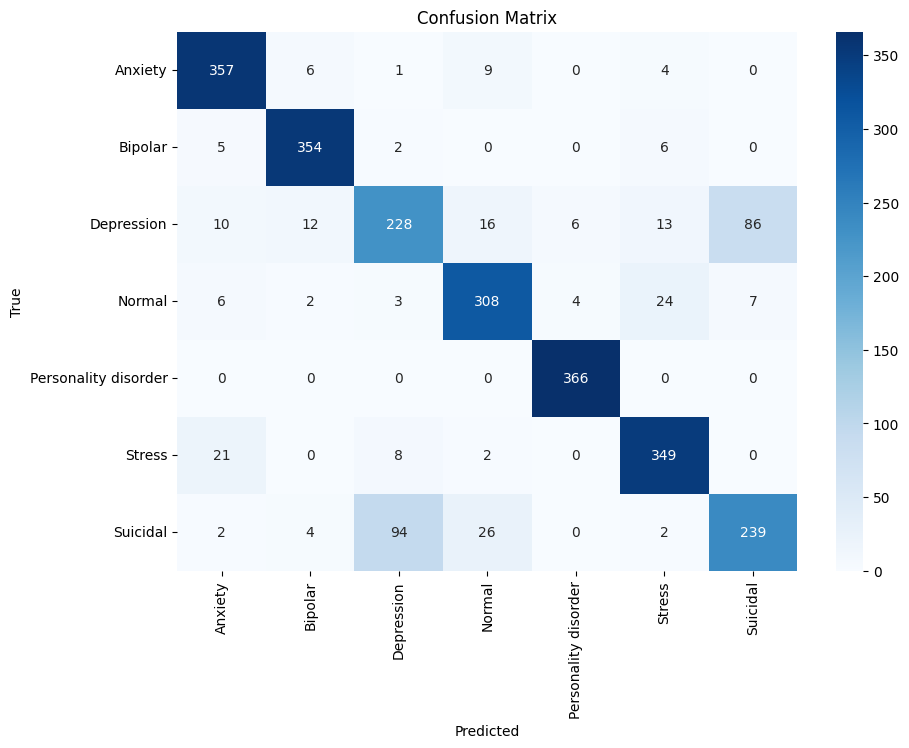

In [21]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print(classification_report(test_labels, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save and Load Model and Tokenizer

In [22]:
# Save the trained model and tokenizer
trainer.save_model("saved_mental_status_bert")  # Save the model to the specified directory
tokenizer.save_pretrained("saved_mental_status_bert")  # Save the tokenizer


import pickle

pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))

Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


In [23]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved paths
model = AutoModelForSequenceClassification.from_pretrained("saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("saved_mental_status_bert")

label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

Loading weights: 100%|██████████| 201/201 [00:00<00:00, 310.52it/s, Materializing param=classifier.weight]                                      


# Detection System

In [24]:
# Detection System (Example)
def detect_anxiety(text):
    cleaned_text = clean_statement(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

# Test detection system with a mixture of normal, anxiety, bipolar, depression, suicide, etc.
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I can't stop thinking about what will happen if things go wrong.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]

# Assuming the detect_anxiety function is already defined and takes a sentence as input
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")


Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: Anxiety

Sentence: I can't stop thinking about what will happen if things go wrong.
Predicted class: Normal

Sentence: Lately, I've been on a high, feeling like I can do anything!
Predicted class: Anxiety

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: Normal

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: Normal

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: Anxiety

Sentence: I had a really good day, spent some time with my friends.
Predicted class: Normal

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: Normal

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: Suicidal

Sentence: I'm okay today, but sometimes I get really anxious for no reason.
Predicted class: Anxiety



# Downlaod Model To Your PC Directly

In [27]:
# Save trained model and tokenizer locally (NO Colab code)
# SAFE local save for Windows (disable safetensors)

import os
import shutil
import pickle
import torch

model_save_path = "saved_mental_status_bert"

# Remove folder if exists (safety)
if os.path.exists(model_save_path):
    shutil.rmtree(model_save_path)

# Save model using torch (NO safetensors)
model.save_pretrained(model_save_path, safe_serialization=False)
tokenizer.save_pretrained(model_save_path)

# Save label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

print("✅ Model, tokenizer, and label encoder saved successfully!")


Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

✅ Model, tokenizer, and label encoder saved successfully!
